# Creating oxidation states lists

We have data-mined a list of oxidation states based on the structures reported in the Inorganic Crystal Structure Database (as of Sep 2024). This tutorial demonstrates how SMACT can be used to filter this pre-compiled list to produce lists of oxidation states that can be used in SMACT workflows.

## 1. Getting started



[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/WMD-group/SMACT/blob/master/docs/tutorials/filtering_icsd_oxidation_states.ipynb)

In [ ]:
# Install the required packages
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install "smact[strict] @ git+https://github.com/WMD-group/SMACT.git@master" --quiet

!pip install pandarallel "matplotlib-venn[shapely]" --quiet

In [ ]:
from smact.utils.oxidation import ICSD24OxStatesFilter
from smact.structure_prediction.utilities import parse_spec
import seaborn as sns
import matplotlib.pyplot as plt
import dash
import plotly.graph_objects as go
import plotly.io as pio
from dash.dependencies import Input, Output
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pymatviz as pmv
from matplotlib_venn import venn3
import smact
from smact.utils.composition import comp_maker
from smact.screening import smact_filter, smact_validity
from mp_api.client import MPRester
import pandas as pd
from pandarallel import pandarallel
from pprint import pprint

# Interactive plotly figures don't show up on GitHub.
# https://github.com/plotly/plotly.py/issues/931
# change renderer from "png" to "notebook" to get hover tooltips back
# (but blank plots on GitHub!)
pio.renderers.default = "png"
sns.set_theme(context="notebook", style="ticks", palette="colorblind")

## 2. Using the oxidation states filter

In [ ]:
# Initialise the oxidation state filter
ox_filter = ICSD24OxStatesFilter()
ox_states_df = ox_filter.ox_states_df
ox_states_df.head(15)

,element,oxidation_state,results_count
0,H,-9,0
1,H,-8,0
2,H,-7,0
3,H,-6,0
4,H,-5,0
5,H,-4,0
6,H,-3,0
7,H,-2,0
8,H,-1,3442
9,H,0,2738


The above code output presents a Dataframe of the occurrences of elements in particular oxidation states mined from the ICSD in September 2024. Here the results count refers to the number of structures in the ICSD that contain the element in a given oxidation state. The mininig process was quite simple, as such there are many 0 values in the table. We can use the built-in method `get_species_occurrences_df` to return a dataframe of the elements, the ionic species reported for a given element, the number of occurrences of a species in the ICSD and the species' proportion with respect to all ionic species of a given element.

In [ ]:
# Return the dataframe with non-zero results
ox_filter.get_species_occurrences_df(sort_by_occurrences=False)

,element,species,results_count,species_proportion (%)
0,H,H-,3442,9.136274
1,H,H+,34232,90.863726
2,Li,Li+,10513,100.000000
3,Be,Be2+,1131,100.000000
4,B,B5-,3,0.048185
...,...,...,...,...
400,Cm,Cm4+,5,13.157895
401,Bk,Bk3+,10,71.428571
402,Bk,Bk4+,4,28.571429
403,Cf,Cf3+,17,100.000000


In [ ]:
# We can also return the dataframe sorted by occurrences (results_count)
ox_filter.get_species_occurrences_df(sort_by_occurrences=True)

,element,species,results_count,species_proportion (%)
0,O,O2-,116910,99.557183
1,H,H+,34232,90.863726
2,Si,Si4+,18248,97.786828
3,Na,Na+,17539,100.000000
4,Ca,Ca2+,16605,99.981936
...,...,...,...,...
400,Ca,Ca+,3,0.018064
401,B,B5-,3,0.048185
402,In,In2-,3,0.080623
403,Pa,Pa3+,3,5.882353


To directly produce a list of oxidation states that can be used in SMACT workflows, we have built in functions which can be used to filter the data. The method `filter` can be used to filter the data based on the number of occurrences of the oxidation state in the ICSD. The function takes the following arguments:

- `consensus`: Minimum number of occurrences in literature for an ion to be considered valid. It helps to avoid unphysical species which somehow found their way into ICSD (e.g. H<sup>3+</sup>). Default is 3.
- `include_zero`: Include oxidation state of zero in the filtered list. Default is False.
- `commonality`: Excludes species below a certain proportion of appearances in literature with respect to the total number of reports of a given element (after the consensus threshold has been applied). "Low" includes all species, "medium" excludes rare species below 10% occurrence, and "high" excludes non-majority species below 50% occurrence. You can also specify your own threshold (float or int). Default is "low".

In [ ]:
# Return a dataframe with columns element and oxidation state,
# where oxidation state contains the oxidation states of the element in the ICSD which exceed the threshold
ox_filter.filter(consensus=1, include_zero=False, commonality=11)

,element,oxidation_state
0,H,1
1,Li,1
2,Be,2
3,B,3
4,C,2 4
...,...,...
88,Am,3 4
89,Cm,3 4
90,Bk,3 4
91,Cf,3


Using the same set of arguments we can also extract the list of ionic species present above a given threshold.

In [ ]:
species_list_100 = ox_filter.get_species_list(
    consensus=1, include_zero=False, commonality=11
)
species_list_100

['H+',
 'Li+',
 'Be2+',
 'B3+',
 'C2+',
 'C4+',
 'N3-',
 'O2-',
 'F-',
 'Na+',
 'Mg2+',
 'Al3+',
 'Si4+',
 'P5+',
 'S2-',
 'S6+',
 'Cl-',
 'K+',
 'Ca2+',
 'Sc3+',
 'Ti4+',
 'V3+',
 'V4+',
 'V5+',
 'Cr3+',
 'Mn2+',
 'Mn3+',
 'Mn4+',
 'Fe2+',
 'Fe3+',
 'Co2+',
 'Co3+',
 'Ni2+',
 'Ni3+',
 'Cu+',
 'Cu2+',
 'Zn2+',
 'Ga3+',
 'Ge4+',
 'As3-',
 'As3+',
 'As5+',
 'Se2-',
 'Se4+',
 'Br-',
 'Kr2+',
 'Rb+',
 'Sr2+',
 'Y3+',
 'Zr4+',
 'Nb5+',
 'Mo5+',
 'Mo6+',
 'Tc3+',
 'Tc4+',
 'Tc7+',
 'Ru2+',
 'Ru3+',
 'Ru4+',
 'Ru5+',
 'Rh3+',
 'Rh4+',
 'Pd2+',
 'Pd4+',
 'Ag+',
 'Cd2+',
 'In3+',
 'Sn2+',
 'Sn4+',
 'Sb3-',
 'Sb3+',
 'Sb5+',
 'Te2-',
 'Te4+',
 'Te6+',
 'I-',
 'I5+',
 'Xe2+',
 'Xe6+',
 'Cs+',
 'Ba2+',
 'La3+',
 'Ce3+',
 'Ce4+',
 'Pr3+',
 'Nd3+',
 'Pm3+',
 'Sm3+',
 'Eu2+',
 'Eu3+',
 'Gd3+',
 'Tb3+',
 'Dy3+',
 'Ho3+',
 'Er3+',
 'Tm3+',
 'Yb2+',
 'Yb3+',
 'Lu3+',
 'Hf4+',
 'Ta5+',
 'W6+',
 'Re3+',
 'Re4+',
 'Re5+',
 'Re6+',
 'Re7+',
 'Os2+',
 'Os4+',
 'Os5+',
 'Os6+',
 'Ir3+',
 'Ir4+',
 'Ir5+',
 'Pt

### Writing the filtered oxidation states to a file

The filtered oxidation states can be written to a file using the `write` method. This method takes the `consensus`, `include_zero` and `commonality` arguments as well as:

- `filename`: The name of the file to write the filtered oxidation states to.
- `comment`: A comment to write to the file.

In [ ]:
# Write the results to a file
ox_filter.write(
    "oxidation_states_icsd24_100.txt",
    consensus=1,
    include_zero=False,
    commonality=11,
    comment="Oxidation states of elements in the 2024 version of the ICSD",
)

In [ ]:
# Read the results from a file
with open("oxidation_states_icsd24_100.txt", "r") as f:
    print(f.read())

#
# Oxidation state set
# Source: ICSD (2024), filtered for 11 commonality of reports
#
# Oxidation states of elements in the 2024 version of the ICSD
#
H 1
He
Li 1
Be 2
B 3
C 2 4
N -3
O -2
F -1
Ne
Na 1
Mg 2
Al 3
Si 4
P 5
S -2 6
Cl -1
Ar
K 1
Ca 2
Sc 3
Ti 4
V 3 4 5
Cr 3
Mn 2 3 4
Fe 2 3
Co 2 3
Ni 2 3
Cu 1 2
Zn 2
Ga 3
Ge 4
As -3 3 5
Se -2 4
Br -1
Kr 2
Rb 1
Sr 2
Y 3
Zr 4
Nb 5
Mo 5 6
Tc 3 4 7
Ru 2 3 4 5
Rh 3 4
Pd 2 4
Ag 1
Cd 2
In 3
Sn 2 4
Sb -3 3 5
Te -2 4 6
I -1 5
Xe 2 6
Cs 1
Ba 2
La 3
Ce 3 4
Pr 3
Nd 3
Pm 3
Sm 3
Eu 2 3
Gd 3
Tb 3
Dy 3
Ho 3
Er 3
Tm 3
Yb 2 3
Lu 3
Hf 4
Ta 5
W 6
Re 3 4 5 6 7
Os 2 4 5 6
Ir 3 4 5
Pt 2 4
Au 1 3
Hg 2
Tl 1 3
Pb 2
Bi 3
Po -2 2 4
At
Rn
Fr
Ra 2
Ac 3
Th 4
Pa 4 5
U 4 6
Np 3 4 5 6
Pu 3 4 6
Am 3 4
Cm 3 4
Bk 3 4
Cf 3
Es 3
Fm
Md
No
Lr



## Using custom Oxidation States in SMACT workflows

The oxidation states filter function can be used to create SMACT-compatible oxidation state lists which can be used with the `smact_validity` function for check if a compound passes the SMACT chemical rules or with the `smact_filter` function to enumerate "SMACT-sensible" compositions.

### SMACT Filter
We can enumerate SMACT-sensible compositions using the `smact_filter` function. Here, we will consider the `Zn-Ti-O` system and enumerate all possible compositions of Zn, Ti and O that pass the SMACT chemical rules. 

In [ ]:
# Define the elements for which we want to generate the allowed combinations
elements = ["Zn", "Ti", "O"]

# Create an element dictionary
space = smact.element_dictionary(elements)

# Enumerate the allowed combinations
allowed_combinations_smact14 = smact_filter(
    space.values(), threshold=8, oxidation_states_set="smact14"
)
allowed_combinations_icsd24_100 = smact_filter(
    space.values(), threshold=8, oxidation_states_set="oxidation_states_icsd24_100.txt"
)
allowed_combinations_icsd24 = smact_filter(
    space.values(), threshold=8, oxidation_states_set="icsd24"
)

# Convert to Pymatgen Composition objects
smact14_comps = list(set([comp_maker(c) for c in allowed_combinations_smact14]))
icsd24_100_comps = list(set([comp_maker(c) for c in allowed_combinations_icsd24_100]))
icsd24_comps = list(set([comp_maker(c) for c in allowed_combinations_icsd24]))

# Print the number of allowed combinations
print(
    f"Number of allowed combinations in the SMACT14 set: {len(allowed_combinations_smact14)}"
)
print(
    f"Number of allowed combinations in the ICSD24 (consensus=1, include_zero=False, commonality=11) set: {len(allowed_combinations_icsd24_100)}"
)
print(
    f"Number of allowed combinations in the ICSD24 set: {len(allowed_combinations_icsd24)}"
)

Number of allowed combinations in the SMACT14 set: 170
Number of allowed combinations in the ICSD24 (consensus=1, include_zero=False, commonality=11) set: 10
Number of allowed combinations in the ICSD24 set: 64


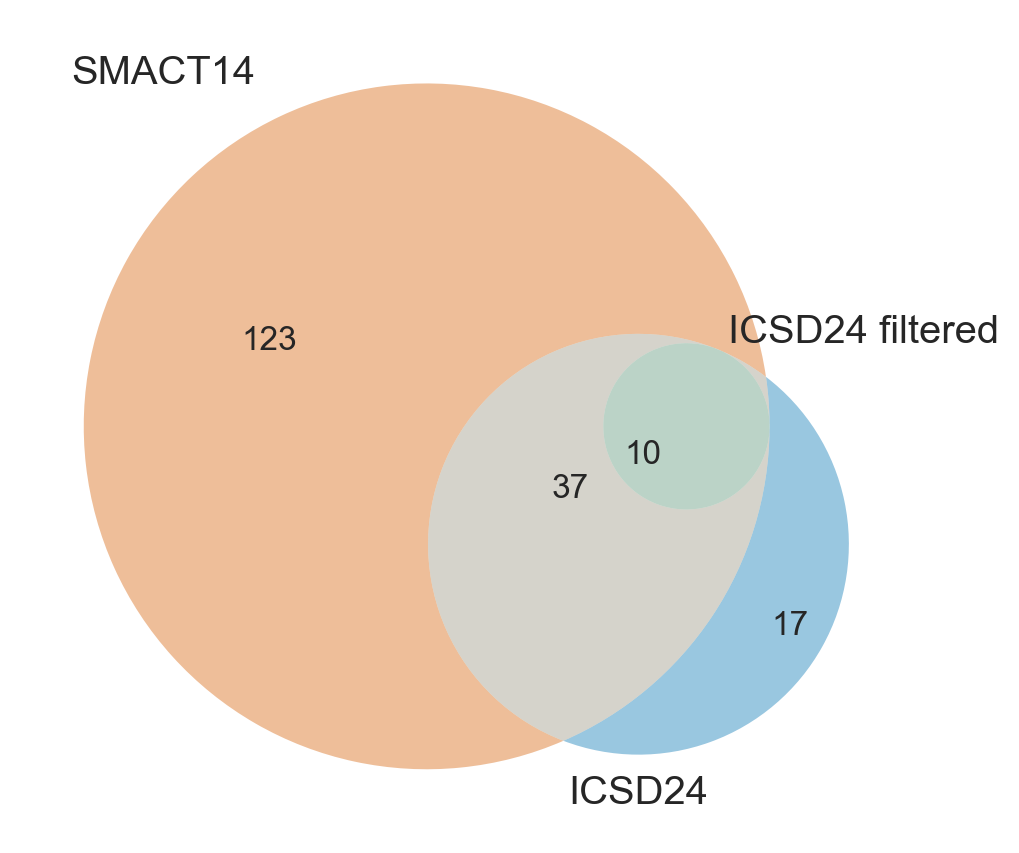

In [ ]:
# Create the unique sets to make venn diagrams

smact14_set = set(smact14_comps)
icsd24_100_set = set(icsd24_100_comps)
icsd24_set = set(icsd24_comps)

# Create the venn diagram

fig, ax = plt.subplots(figsize=(5, 5))

v = venn3(
    (smact14_set, icsd24_100_set, icsd24_set),
    set_labels=("SMACT14", "ICSD24 filtered", "ICSD24"),
)

plt.show()

The Venn diagram provides a visual representation of the number of compositions that pass the SMACT filter using different sets of oxidation states.
As we can see, the number of compositions that pass the SMACT filter changes depending on the oxidation states used in the filter. This suggests that the choice of oxidation states is important when using the SMACT filter. Additionally, some oxidation state lists can result in unique compositions that would not be found using other oxidation state lists.

It is expected that the filtered ICSD24 list would be a subset of the ICSD24 oxidation state list. The argument settings reduce the possible compositions such that all of the enumerated compositions are a subset of the composition space enumerated using the 2014 SMACT oxidation state list.

In [ ]:
# Show the compositions unique to the ICSD24 set
pprint(icsd24_set - smact14_set)

{Composition('Zn3+:1 Ti4+:1 O-:7'),
 Composition('Zn3+:2 Ti4+:1 O2-:5'),
 Composition('Zn3+:4 Ti4+:1 O2-:8'),
 Composition('Zn3+:2 Ti4+:2 O2-:7'),
 Composition('Zn3+:1 Ti3+:1 O-:6'),
 Composition('Zn3+:1 Ti3+:1 O2-:3'),
 Composition('Zn3+:3 Ti3+:1 O2-:6'),
 Composition('Zn3+:1 Ti3+:3 O2-:6'),
 Composition('Zn3+:1 Ti2+:1 O-:5'),
 Composition('Zn3+:2 Ti2+:1 O-:8'),
 Composition('Zn3+:2 Ti2+:1 O2-:4'),
 Composition('Zn3+:4 Ti2+:1 O2-:7'),
 Composition('Zn3+:1 Ti2+:2 O-:7'),
 Composition('Zn3+:2 Ti2+:2 O2-:5'),
 Composition('Zn3+:2 Ti2+:3 O2-:6'),
 Composition('Zn3+:2 Ti2+:4 O2-:7'),
 Composition('Zn3+:2 Ti2+:5 O2-:8')}


We can see that from the list above, the unique compositions from using the ICSD 24 list all contain Zn<sup>3+</sup> which shows that it is not present in the manually compiled 2014 SMACT oxidation states list. Application of filtering criteria eliminates the compositions conataining the Zn<sup>3+</sup> oxidation state, showing that while present in the ICSD, it is not a common oxidation state for Zn.

In [ ]:
pprint(icsd24_100_set - smact14_set)

set()


### SMACT Validity
We can check if a compound passes the SMACT chemical rules using the `smact_validity` function.

Note: This function is quite simple and as such currently fails for mixed valence compounds. This is something we are working on improving in the future.

In [ ]:
# Query the Materials Project API for all materials that have been experimentally synthesised
# You'll need to input your API key if it's not already set in the environment
with MPRester(use_document_model=False) as mpr:
    docs = mpr.materials.summary.search(
        theoretical=False, fields=["material_id", "formula_pretty", "energy_above_hull"]
    )

# Create a dataframe from the results

mp_df = pd.DataFrame(docs)
mp_df.head(10)

Retrieving SummaryDoc documents:   0%|          | 0/49318 [00:00<?, ?it/s]

,formula_pretty,material_id,energy_above_hull
0,Ac,mp-10018,0.021639
1,Ac2O3,mp-11107,0.000000
2,AcBr3,mp-27972,0.000000
3,AcBrO,mp-30274,0.000000
4,AcCl3,mp-27971,0.000000
5,AcClO,mp-30273,0.000000
6,AcH2,mp-24147,0.000000
7,Ag,mp-10597,0.007669
8,Ag,mp-124,0.002127
9,Ag,mp-8566,0.000000


In [ ]:
# Sort the dataframe by formula_pretty and energy_above_hull and drop duplicate formula by keeping the lowest energy above hull
mp_df = (
    mp_df.sort_values(["formula_pretty", "energy_above_hull"])
    .drop_duplicates("formula_pretty")
    .reset_index(drop=True)
)
mp_df.head(10)

,formula_pretty,material_id,energy_above_hull
0,Ac,mp-10018,0.021639
1,Ac2O3,mp-11107,0.000000
2,AcBr3,mp-27972,0.000000
3,AcBrO,mp-30274,0.000000
4,AcCl3,mp-27971,0.000000
5,AcClO,mp-30273,0.000000
6,AcH2,mp-24147,0.000000
7,Ag,mp-8566,0.000000
8,Ag(AuF4)2,mp-18125,0.000000
9,Ag(BCl)6,mp-567334,0.000000


In [ ]:
supplied_oxidation_states = [
    "smact14",
    "icsd24",
    "icsd16",
    "pymatgen_sp",
    "oxidation_states_icsd24_100.txt",
]

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
for ox_list in supplied_oxidation_states:
    mp_df[f"{ox_list}"] = mp_df["formula_pretty"].parallel_apply(
        lambda x: smact_validity(x, oxidation_states_set=ox_list)
    )

mp_df.head(10)

,formula_pretty,material_id,energy_above_hull,smact14,icsd24,icsd16,pymatgen_sp,oxidation_states_icsd24_100.txt
0,Ac,mp-10018,0.021639,True,True,True,True,True
1,Ac2O3,mp-11107,0.000000,True,True,True,True,True
2,AcBr3,mp-27972,0.000000,True,True,True,True,True
3,AcBrO,mp-30274,0.000000,True,True,True,True,True
4,AcCl3,mp-27971,0.000000,True,True,True,True,True
5,AcClO,mp-30273,0.000000,True,True,True,True,True
6,AcH2,mp-24147,0.000000,True,False,False,False,False
7,Ag,mp-8566,0.000000,True,True,True,True,True
8,Ag(AuF4)2,mp-18125,0.000000,True,True,True,True,False
9,Ag(BCl)6,mp-567334,0.000000,False,False,False,False,False


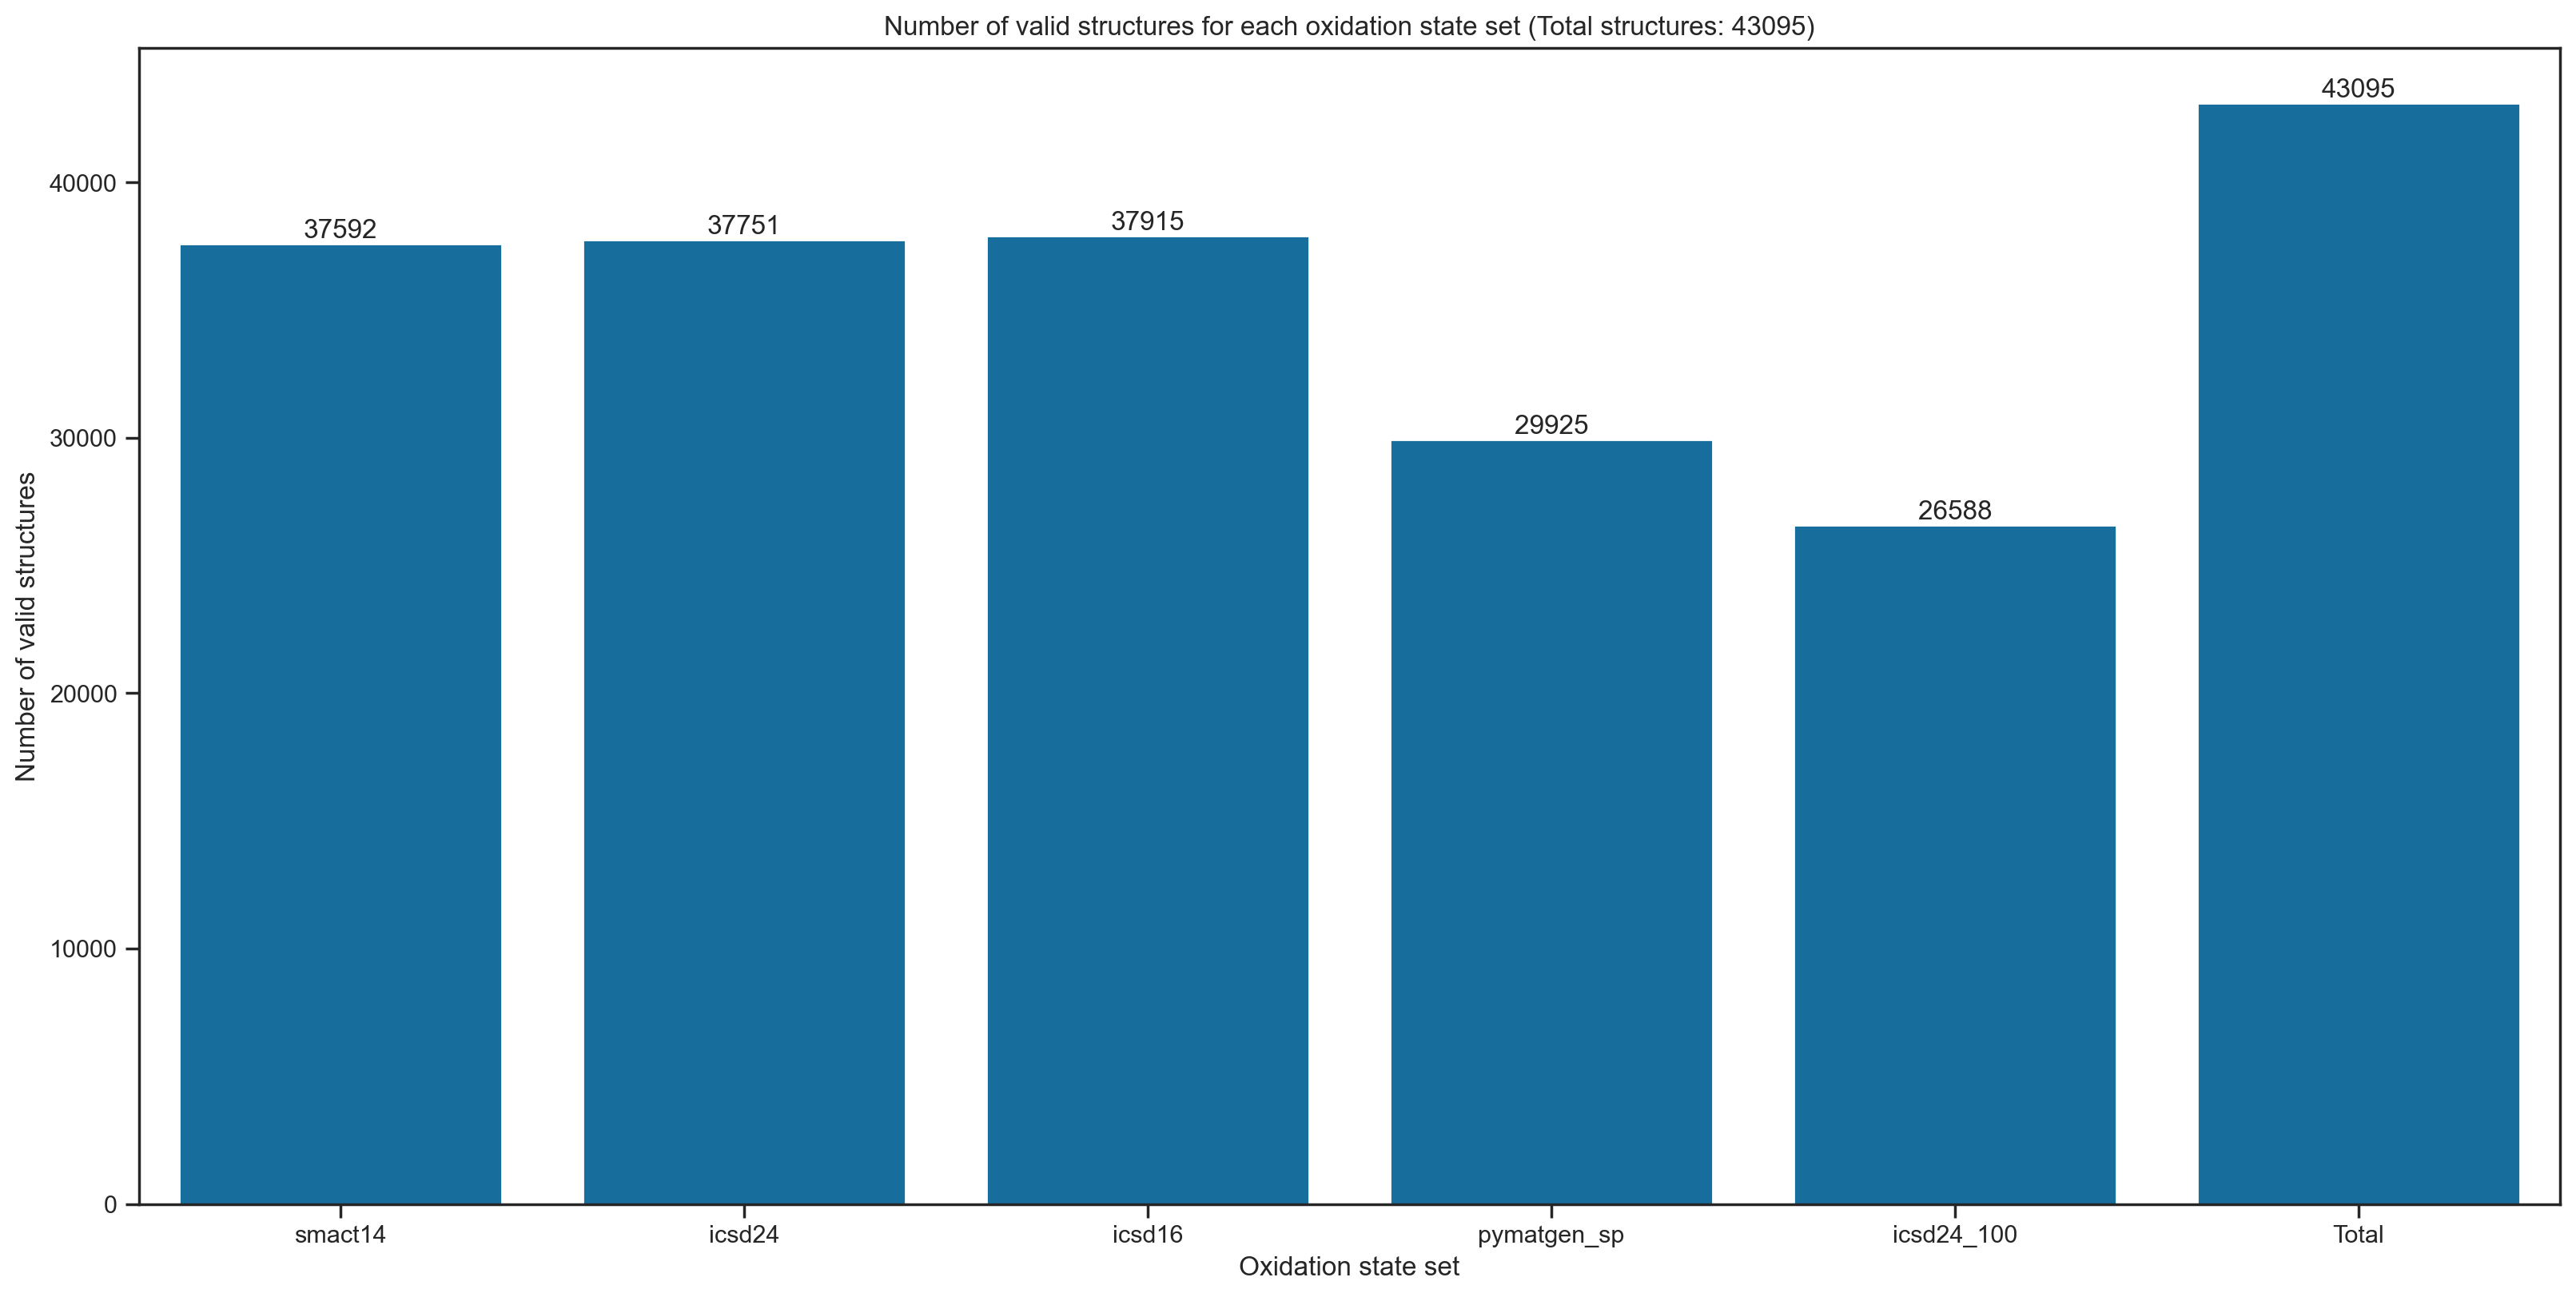

In [ ]:
# Plot the number of valid structures for each oxidation state set


valid_counts = mp_df[[f"{ox_list}" for ox_list in supplied_oxidation_states]].sum()
# Append the total number of structures to the valid_counts series
valid_counts = pd.concat([valid_counts, pd.Series([len(mp_df)], index=["Total"])])
# Relabel the index oxidation_states_icsd24_100.txt to icsd24_100
valid_counts.rename(
    index={"oxidation_states_icsd24_100.txt": "icsd24_100"}, inplace=True
)
fig, ax = plt.subplots(figsize=(16, 8))
# Show the numbers on the bars
for i, v in enumerate(valid_counts.values):
    ax.text(i, v + 10, str(v), ha="center", va="bottom")
sns.barplot(x=valid_counts.index, y=valid_counts.values, ax=ax)
ax.set_xlabel("Oxidation state set")
ax.set_ylabel("Number of valid structures")

#
# Include total number of structures in the title

total_structures = len(mp_df)
ax.set_title(
    f"Number of valid structures for each oxidation state set (Total structures: {total_structures})"
)
plt.show()